##**Install Required Libraries**

In [6]:
!pip install easyocr opencv-python pillow pandas matplotlib transformers torch

##**Import Libraries**

In [7]:
import cv2
import numpy as np
import pytesseract
import easyocr
import pandas as pd
import matplotlib.pyplot as plt
import re

##**Upload Receipt Image**

In [8]:
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]

Saving reciept.webp to reciept (3).webp


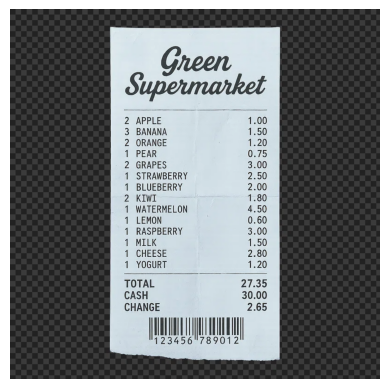

In [9]:
plt.imshow(cv2.imread(image_path))
plt.axis("off")
plt.show()

##**Image Preprocessing (OpenCV)**

In [10]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    enhanced = cv2.equalizeHist(blur)
    _, thresh = cv2.threshold(enhanced, 150, 255, cv2.THRESH_BINARY)

    return thresh

(np.float64(-0.5), np.float64(799.5), np.float64(799.5), np.float64(-0.5))

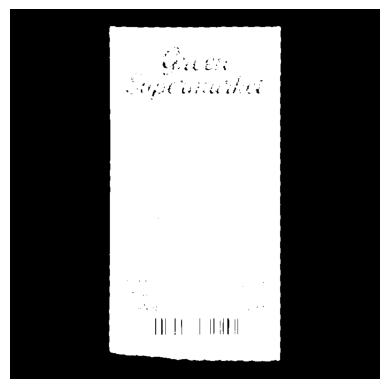

In [11]:
processed_image = preprocess_image(image_path)

plt.imshow(processed_image, cmap="gray")
plt.axis("off")

##**OCR Text Extraction**

In [12]:
reader = easyocr.Reader(['en'])

def extract_text(image_path):
    result = reader.readtext(image_path, detail=0)
    return "\n".join(result)

ocr_text = extract_text(image_path)
print(ocr_text)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Gneen
Supenmanket
2
APPLE
1.00
BANANA
1.50
2
ORANGE
1.20
PEAR
0.75
GRAPES
3.00
STRAWBERRY
2.50
BLUEBERRY
2.00
2
KIWI
1.80
WATERMELON
4.50
LEMON
0.60
RASPBERRY
3.00
MILK
1.50
CHEESE
2.80
YOGURT
1.20
TOTAL
27.35
CASH
30.00
CHANGE
2.65
'123456"/789012


##**Parse OCR Text**

In [13]:
import pandas as pd
import re

def parse_receipt_line_by_line(text):
    """
    Parses OCR receipt text line by line.
    Handles cases where quantity, item, and price are on separate lines.
    """
    lines = [line.strip() for line in text.split("\n") if line.strip()]
    data = []

    i = 0
    while i < len(lines):
        line = lines[i]

        # Case 1: Line is a quantity (integer)
        if re.match(r'^\d+$', line):
            qty = int(line)
            # Next line should be item
            if i+1 < len(lines):
                item = lines[i+1]
            else:
                break
            # Next next line should be price
            if i+2 < len(lines) and re.match(r'^\d+\.\d{2}$', lines[i+2]):
                price = float(lines[i+2])
            else:
                price = 0.0
            data.append([item, qty, price])
            i += 3

        # Case 2: Line is item (letters), next line is price
        elif re.match(r'^[A-Za-z\s]+$', line) and i+1 < len(lines) and re.match(r'^\d+\.\d{2}$', lines[i+1]):
            item = line
            qty = 1
            price = float(lines[i+1])
            data.append([item, qty, price])
            i += 2
        else:
            i += 1

    df = pd.DataFrame(data, columns=["Item", "Quantity", "Price"])
    return df

# Usage
df = parse_receipt_line_by_line(ocr_text)
df

,Item,Quantity,Price
0,APPLE,2,1.00
1,BANANA,1,1.50
2,ORANGE,2,1.20
3,PEAR,1,0.75
4,GRAPES,1,3.00
5,STRAWBERRY,1,2.50
6,BLUEBERRY,1,2.00
7,KIWI,2,1.80
8,WATERMELON,1,4.50
9,LEMON,1,0.60


##**Expense Categorization**

In [14]:
# Category mapping
category_map = {
    "milk": "Dairy",
    "cheese": "Dairy",
    "yogurt": "Dairy",
    "bread": "Bakery",
    "cake": "Bakery",
    "chicken": "Meat",
    "beef": "Meat",
    "apple": "Fruits",
    "banana": "Fruits",
    "orange": "Fruits",
    "grapes": "Fruits",
    "kiwi": "Fruits",
    "watermelon": "Fruits",
    "lemon": "Fruits",
    "strawberry": "Fruits",
    "blueberry": "Fruits",
    "raspberry": "Fruits",
    "chips": "Snacks",
    "biscuit": "Snacks"
}

# Function to assign category
def categorize_item(item):
    item = item.lower()
    for key in category_map:
        if key in item:
            return category_map[key]
    return "Other"

# Apply categorization
df["Category"] = df["Item"].apply(categorize_item)
df

,Item,Quantity,Price,Category
0,APPLE,2,1.00,Fruits
1,BANANA,1,1.50,Fruits
2,ORANGE,2,1.20,Fruits
3,PEAR,1,0.75,Other
4,GRAPES,1,3.00,Fruits
5,STRAWBERRY,1,2.50,Fruits
6,BLUEBERRY,1,2.00,Fruits
7,KIWI,2,1.80,Fruits
8,WATERMELON,1,4.50,Fruits
9,LEMON,1,0.60,Fruits


##**Calculate Spending & Overspending**

In [15]:
# Total spending
total_spending = df["Price"].sum()

# Summary per category
category_summary = df.groupby("Category")["Price"].sum().reset_index()
category_summary["Percentage"] = (category_summary["Price"] / total_spending) * 100

# Overspending flag (threshold 40%)
def overspending_flag(percentage, threshold=40):
    return "High Spending" if percentage > threshold else "Normal"

category_summary["Status"] = category_summary["Percentage"].apply(lambda x: overspending_flag(x))
category_summary

,Category,Price,Percentage,Status
0,Dairy,5.50,6.296508,Normal
1,Fruits,21.10,24.155695,Normal
2,Other,60.75,69.547796,High Spending


##**Visualization**

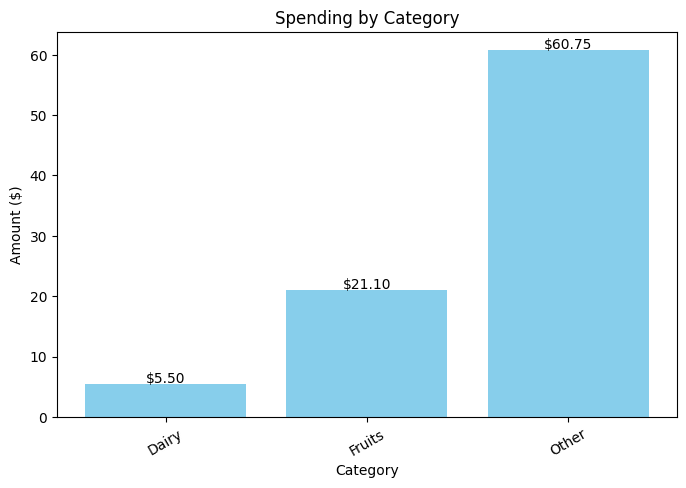

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(category_summary["Category"], category_summary["Price"], color="skyblue")
plt.title("Spending by Category")
plt.xlabel("Category")
plt.ylabel("Amount ($)")
plt.xticks(rotation=30)

# Add exact amounts on top of bars
for i, v in enumerate(category_summary["Price"]):
    plt.text(i, v + 0.2, f"${v:.2f}", ha='center')

plt.show()

##**LLM Integration**

In [18]:
!pip install langchain_groq

In [21]:
from langchain_groq import ChatGroq
from google.colab import userdata
from IPython.display import Markdown
import os
os.environ["GROQ_API_KEY"] = userdata.get("Groq_Api_Key")

llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.0,
    api_key=os.environ["GROQ_API_KEY"]
)

In [25]:
#prompt
prompt = f"""
You are a professional financial advisor.

Analyze the spending summary below and provide ONLY the following in concise bullet points:

1. Top overspending categories (by amount or percentage)
2. Budget improvement tips
3. Practical, actionable saving advice

Instructions:
- One bullet per point
- Short, professional sentences
- No extra commentary

Spending Summary:
{category_summary.to_string(index=False)}
"""

# -----------------------------
# Get LLM response
# -----------------------------
response = llm.invoke(prompt)

# Display AI financial advice
display(Markdown("### AI FINANCIAL ADVICE"))
display(Markdown(response.content))

### AI FINANCIAL ADVICE

**Top Overspending Categories:**
- Other (69.547796% of total spending)

**Budget Improvement Tips:**
- Reassess and reduce discretionary spending in the 'Other' category.

**Practical Saving Advice:**
- Allocate 30-40% of the 'Other' category budget towards savings or debt repayment.

In [26]:
print(" STRUCTURED DATA")
display(df)

print("\n CATEGORY SUMMARY")
display(category_summary)

print("\n AI FINANCIAL ADVICE")
display(Markdown(response.content))

 STRUCTURED DATA


,Item,Quantity,Price,Category
0,APPLE,2,1.00,Fruits
1,BANANA,1,1.50,Fruits
2,ORANGE,2,1.20,Fruits
3,PEAR,1,0.75,Other
4,GRAPES,1,3.00,Fruits
5,STRAWBERRY,1,2.50,Fruits
6,BLUEBERRY,1,2.00,Fruits
7,KIWI,2,1.80,Fruits
8,WATERMELON,1,4.50,Fruits
9,LEMON,1,0.60,Fruits



 CATEGORY SUMMARY


,Category,Price,Percentage,Status
0,Dairy,5.50,6.296508,Normal
1,Fruits,21.10,24.155695,Normal
2,Other,60.75,69.547796,High Spending



 AI FINANCIAL ADVICE


**Top Overspending Categories:**
- Other (69.547796% of total spending)

**Budget Improvement Tips:**
- Reassess and reduce discretionary spending in the 'Other' category.

**Practical Saving Advice:**
- Allocate 30-40% of the 'Other' category budget towards savings or debt repayment.